# COMP 579 Assignment 1

1. Do Not Change the Random Seed
The random seed has been set to ensure reproducibility. Please do not modify it.

2. Guidance for the First Question
For the initial question, fill in the blanks under the sections marked as TODO. Follow the provided structure and complete the missing parts.

3. Approach for Subsequent Questions
For the later questions, we expect you to attempt the solutions independently. You can refer to the examples provided in earlier questions to understand how to 
plot figures and implement solutions.

4. Ensure that the plots you produce for later questions are similar in style and format to those shown in the previous examples.

In [2]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import torch

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Using GPU")
#     print("CUDA version:", torch.version.cuda)
#     import cupy as np
# else:
#     device = torch.device("cpu")
#     print("Using CPU")
#     import numpy as np


np.random.seed(40)

plt.rcParams["figure.figsize"]=10,5

## Q1 Simulator for Bernoulli Bandit

In [3]:
class GaussianBandit:
    """
    A class representing a Gaussian multi-armed bandit.

    Attributes
    ----------
    num_arms : int
        Number of arms in the bandit.
    mean : list or np.ndarray
        List of mean rewards for each arm.
    variance : float
        Variance of the rewards for all arms.

    Methods
    -------
    sample(arm_index)
        Samples a reward from the specified arm based on a Gaussian distribution.
    """

    # TODO:
    def __init__(self, num_arms, mean, variance):
        self.num_arms = num_arms
        self.mean = mean
        self.variance = variance

    def sample(self, arm_index):
        reward = np.random.normal(self.mean[arm_index], self.variance)
        return reward

In [4]:
delta = 0.2
num_arms = 3
means = [0.5 + delta, 0.5, 0.5 - delta]
variance = 0.01
num_samples = 50

three_arm_gaussian_bandit = GaussianBandit(num_arms, means, variance)

# Store the rewards for each arm
action_rewards = []
actions = range(num_arms)

for action in actions:
    # Store 50 samples per action
    rewards = [three_arm_gaussian_bandit.sample(action) for _ in range(num_samples)]
    action_rewards.append(rewards)

### Graphs

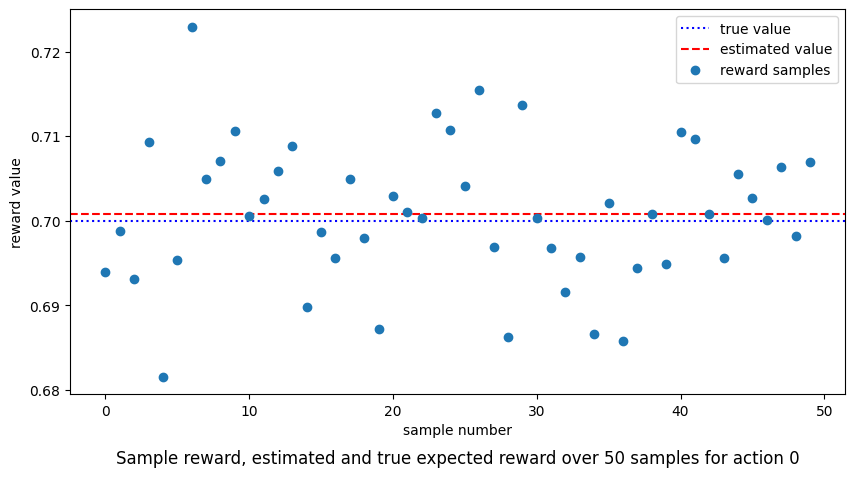

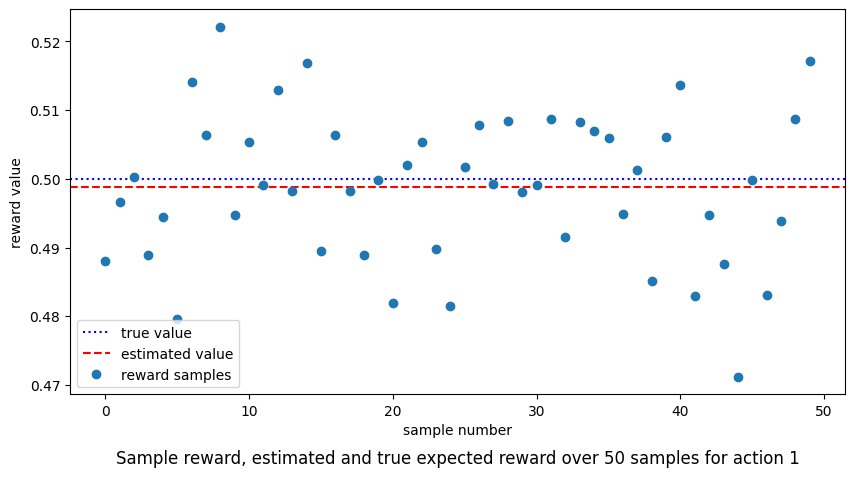

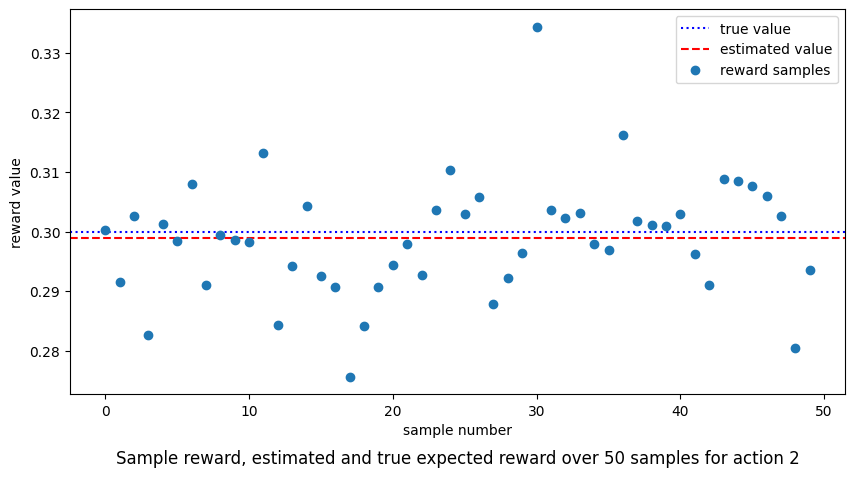

In [5]:
for action in actions:
    fig, ax = plt.subplots()

    true_value = means[action]
    estimated_value = np.mean(action_rewards[action])

    # draw the line of the true value
    line_true_val = ax.axhline(
        y=true_value, color="b", linestyle=":", label="true value"
    )
    # draw the line of the estimated value
    line_est_val = ax.axhline(
        y=estimated_value, color="r", linestyle="--", label="estimated value"
    )
    # plot the reward samples
    (plt_samples,) = ax.plot(action_rewards[action], "o", label="reward samples")

    ax.set_xlabel("sample number")
    ax.set_ylabel("reward value")
    ax.set_title(
        "Sample reward, estimated and true expected reward over 50 samples for action %s"
        % action,
        y=-0.2,
    )

    # show the legend with the labels of the line
    ax.legend(handles=[line_true_val, line_est_val, plt_samples])

## Q2 Estimated Q values

In [6]:
def update(reward_samples, alpha):
    """
    Each call to the function yields the current incremental average of the reward with a fixed learning rate, alpha
    E.g. Inital call returns alpha * reward_samples[0], second call returns prev_val + alpha * (reward_samples[1] - prev_val)
    where prev_val is the value return from the previous call, so on and so forth

    Parameters
    ----------
    reward_samples : array of int
        samples of reward values from one arm of a bandit
    alpha : int
        learning rate parameter for the averaging
    """
    prev_val = 0
    for sample in reward_samples:
        new_val = prev_val + alpha * (sample - prev_val)
        prev_val = new_val
        yield new_val


def updateAvg(reward_samples):
    """
    Each call to the function yields the current incremental average of the reward
    E.g. Inital call returns reward_samples[0], second call returns the average of reward_samples[0] and reward_samples[0], so on and so forth

    Parameters
    ----------
    reward_samples : array of int
        samples of reward values from one arm of a bandit
    """
    prev_val = reward_samples[0]
    n = 1
    # first iteration only updates n to 2, no update to average
    for sample in reward_samples:
        new_val = ((prev_val * n) + sample) / (n + 1)
        prev_val = new_val
        n = n + 1
        yield new_val


def updateDecaying(reward_samples, alpha_0=0.5, lambda_=0.01, p=0.5):
    """
    Each call to the function yields the updated estimate of the action value using an
    improved decaying learning rate.

    Parameters
    ----------
    reward_samples : array-like of int or float
        Samples of reward values from one arm of a bandit.
    alpha_0 : float, optional
        The initial learning rate (default is 0.5).
    lambda_ : float, optional
        The decay rate constant (default is 0.01).
    p : float, optional
        The power parameter for controlling decay (default is 0.5).
    """
    prev_val = 0
    # Time step starts from 1
    t = 1
    for sample in reward_samples:
        # Decaying learning rate formula
        alpha_t = alpha_0 / (1 + lambda_ * t**p)

        # Update rule
        new_val = prev_val + alpha_t * (sample - prev_val)

        # Update previous value and increment time step
        prev_val = new_val
        t += 1

        # Yield the updated value
        yield new_val

### Graphs

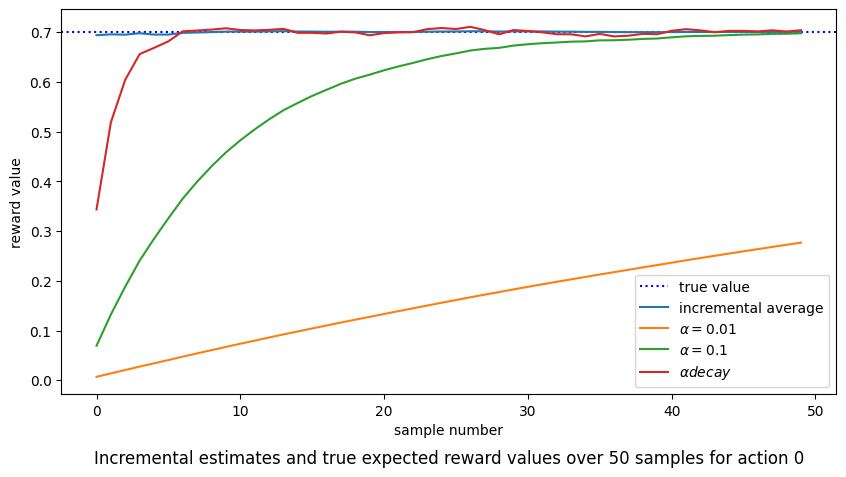

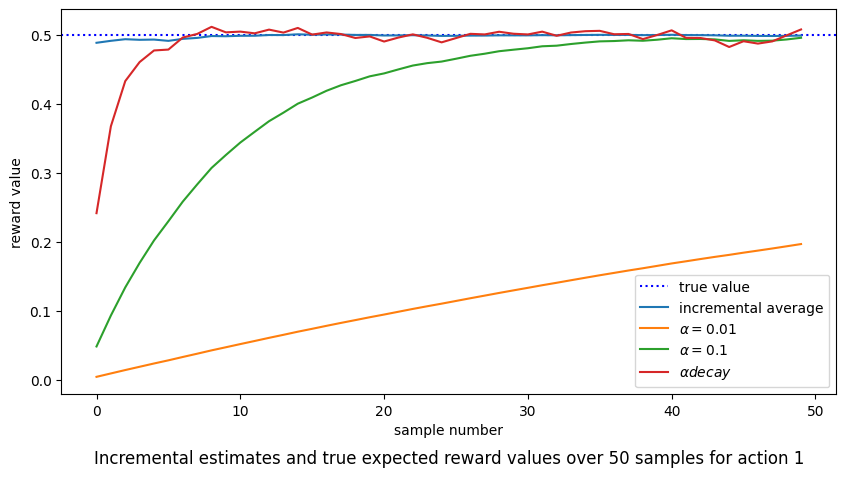

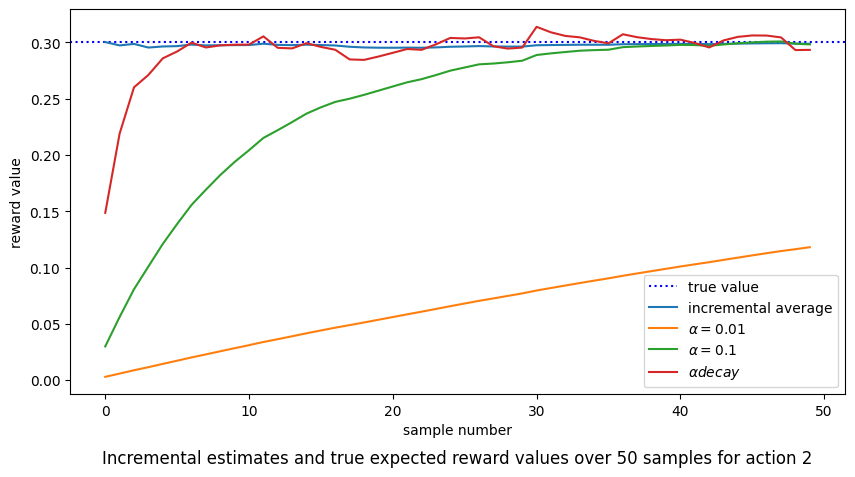

In [7]:
for action in actions:
    fig, ax = plt.subplots()

    # TODO:
    incr_avgs = list(updateAvg(action_rewards[action]))
    alpha_1_percent = list(update(action_rewards[action], 0.01))
    alpha_10_percent = list(update(action_rewards[action], 0.1))
    alpha_decay = list(updateDecaying(action_rewards[action]))
    true_value = means[action]

    # draw the true value line
    line_true_val = ax.axhline(
        y=true_value, color="b", linestyle=":", label="true value"
    )

    # plot incremental values for averaging, alpha = 0.01, alpha = 0.1
    (plt_incr_avgs,) = ax.plot(incr_avgs, label="incremental average")
    (plt_alpha_1_percent,) = ax.plot(alpha_1_percent, label=r"$\alpha = 0.01$")
    (plt_alpha_10_percent,) = ax.plot(alpha_10_percent, label=r"$\alpha = 0.1$")
    (plt_alpha_decay,) = ax.plot(alpha_decay, label=r"$\alpha decay$")

    ax.set_xlabel("sample number")
    ax.set_ylabel("reward value")
    ax.set_title(
        "Incremental estimates and true expected reward values over 50 samples for action %s"
        % action,
        y=-0.2,
    )

    # show the legend with the labels of the line
    ax.legend(
        handles=[
            line_true_val,
            plt_incr_avgs,
            plt_alpha_1_percent,
            plt_alpha_10_percent,
            plt_alpha_decay,
        ]
    )

## Q3 Effect of $α$ on Estimated Q values

In [8]:
num_samples = 100

# arrays of the data generated from 100 runs
incr_avgs_runs = []
alpha_1_percent_runs = []
alpha_10_percent_runs = []
alpha_decay_runs = []


# TODO:
for run in range(100):
    # arrays of data generated from the 3 actions in 1 run
    sample_incr_avgs_by_actions = []
    sample_alpha_1_percent_by_actions = []
    sample_alpha_10_percent_by_actions = []
    sample_alpha_decay_by_actions = []

    for action in actions:
        rewards = [three_arm_gaussian_bandit.sample(action) for _ in range(num_samples)]
        sample_incr_avgs_by_actions.append(list(updateAvg(rewards)))
        sample_alpha_1_percent_by_actions.append(list(update(rewards, 0.01)))
        sample_alpha_10_percent_by_actions.append(list(update(rewards, 0.1)))
        sample_alpha_decay_by_actions.append(list(updateDecaying(rewards)))

    incr_avgs_runs.append(sample_incr_avgs_by_actions)
    alpha_1_percent_runs.append(sample_alpha_1_percent_by_actions)
    alpha_10_percent_runs.append(sample_alpha_10_percent_by_actions)
    alpha_decay_runs.append(sample_alpha_decay_by_actions)

# convert to np arrays
incr_avgs_runs = np.asarray(incr_avgs_runs)
alpha_1_percent_runs = np.asarray(alpha_1_percent_runs)
alpha_10_percent_runs = np.asarray(alpha_10_percent_runs)
alpha_decay_runs = np.asarray(alpha_decay_runs)

### Graphs

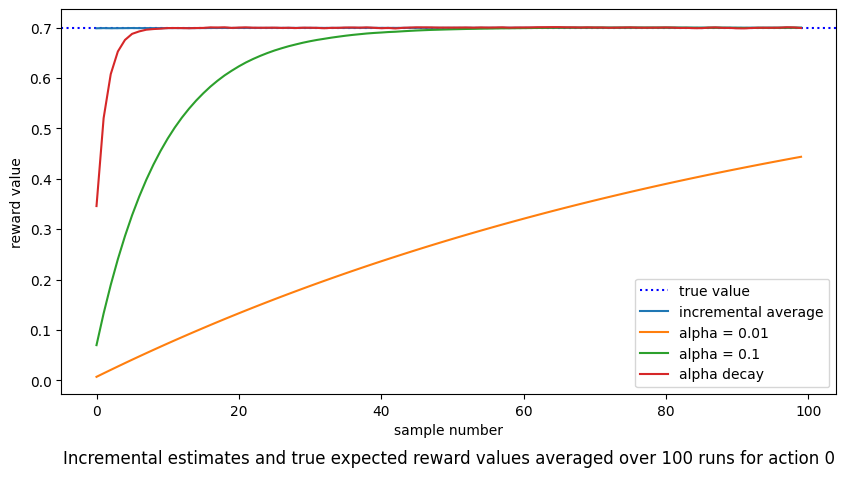

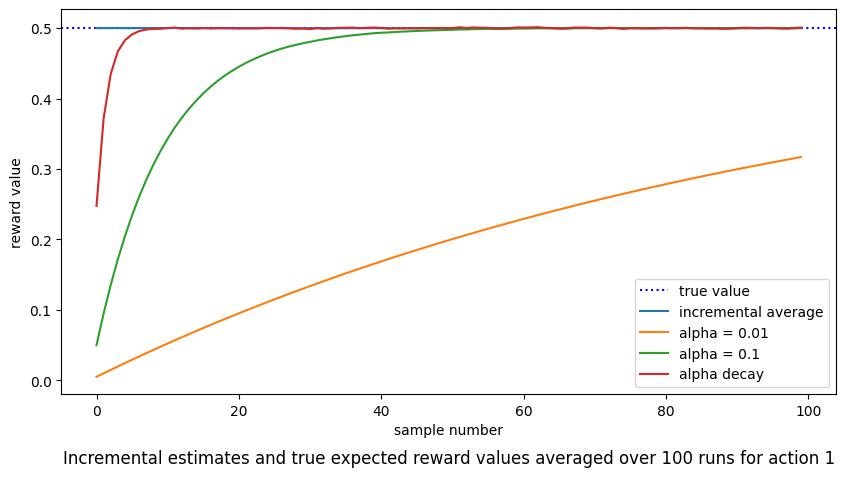

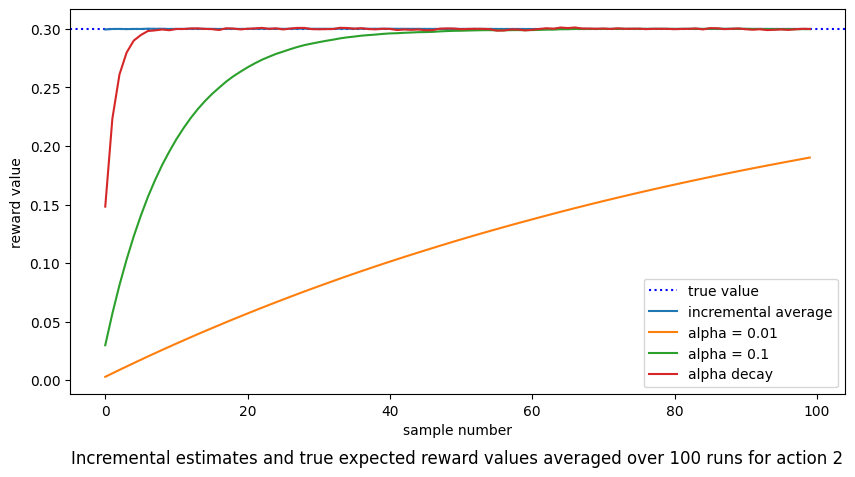

In [9]:
for action in actions:
    fig, ax = plt.subplots()

    # obtain averaged incremental reward values for averaging, alpha = 0.01, alpha = 0.1 and decay alpha over 100 runs
    mean_incr_avgs_by_actions = np.mean(incr_avgs_runs[:, action], axis=0)
    mean_alpha_1_percent_by_actions = np.mean(alpha_1_percent_runs[:, action], axis=0)
    mean_alpha_10_percent_by_actions = np.mean(alpha_10_percent_runs[:, action], axis=0)
    mean_alpha_decay_by_actions = np.mean(alpha_decay_runs[:, action], axis=0)

    true_value = means[action]

    # obtain the standard deviation for averaging, alpha = 0.01, alpha = 0.1 and decay alpha over 100 runs
    std_incr_avgs_by_actions = np.std(incr_avgs_runs[:, action], axis=0)
    std_alpha_1_percent_by_actions = np.std(alpha_1_percent_runs[:, action], axis=0)
    std_alpha_10_percent_by_actions = np.std(alpha_10_percent_runs[:, action], axis=0)
    std_alpha_decay_by_actions = np.std(alpha_decay_runs[:, action], axis=0)

    denumerator = np.sqrt(np.size(incr_avgs_runs[:, action], axis=0))
    # obtain the standard error for averaging, alpha = 0.01, alpha = 0.1 and decay alpha over 100 runs
    std_err_incr_avgs_by_actions = std_incr_avgs_by_actions / (denumerator)
    std_err_alpha_1_percent_by_actions = std_alpha_1_percent_by_actions / (denumerator)
    std_err_alpha_10_percent_by_actions = std_alpha_10_percent_by_actions / (
        denumerator
    )
    std_err_alpha_decay_by_actions = std_alpha_decay_by_actions / (denumerator)

    # draw the true value line
    line_true_val = ax.axhline(
        y=true_value, color="b", linestyle=":", label="true value"
    )

    # draw the averaged incremental reward values for averaging
    (plt_incr_avgs,) = ax.plot(mean_incr_avgs_by_actions, label="incremental average")
    # draw the error bar/area for averaging
    incr_avgs_minus_std_err = mean_incr_avgs_by_actions - std_err_incr_avgs_by_actions
    incr_avgs_plus_std_err = mean_incr_avgs_by_actions + std_err_incr_avgs_by_actions
    ax.fill_between(
        range(0, 100), incr_avgs_minus_std_err, incr_avgs_plus_std_err, alpha=0.3
    )

    # draw the averaged incremental reward values for alpha = 0.01
    (plt_alpha_1_percent,) = ax.plot(
        mean_alpha_1_percent_by_actions, label="alpha = 0.01"
    )
    # draw the error bar/area for alpha = 0.01
    alpha_1_percent_minus_std_err = (
        mean_alpha_1_percent_by_actions - std_err_alpha_1_percent_by_actions
    )
    alpha_1_percent_plus_std_err = (
        mean_alpha_1_percent_by_actions + std_err_alpha_1_percent_by_actions
    )
    ax.fill_between(
        range(0, 100),
        alpha_1_percent_minus_std_err,
        alpha_1_percent_plus_std_err,
        alpha=0.3,
    )

    # draw the averaged incremental reward values for alpha = 0.1
    (plt_alpha_10_percent,) = ax.plot(
        mean_alpha_10_percent_by_actions, label="alpha = 0.1"
    )
    # draw the error bar/area for alpha = 0.1
    alpha_10_percent_minus_std_err = (
        mean_alpha_10_percent_by_actions - std_err_alpha_10_percent_by_actions
    )
    alpha_10_percent_plus_std_err = (
        mean_alpha_10_percent_by_actions + std_err_alpha_10_percent_by_actions
    )
    ax.fill_between(
        range(0, 100),
        alpha_10_percent_minus_std_err,
        alpha_10_percent_plus_std_err,
        alpha=0.3,
    )

    (plt_alpha_decay,) = ax.plot(mean_alpha_decay_by_actions, label="alpha decay")
    alpha_decay_minus_std_err = (
        mean_alpha_decay_by_actions - std_err_alpha_decay_by_actions
    )
    alpha_decay_plus_std_err = (
        mean_alpha_decay_by_actions + std_err_alpha_decay_by_actions
    )
    ax.fill_between(
        range(0, 100), alpha_decay_minus_std_err, alpha_decay_plus_std_err, alpha=0.3
    )

    ax.set_xlabel("sample number")
    ax.set_ylabel("reward value")
    ax.set_title(
        "Incremental estimates and true expected reward values averaged over 100 runs for action %s"
        % action,
        y=-0.2,
    )

    ax.legend(
        handles=[
            line_true_val,
            plt_incr_avgs,
            plt_alpha_1_percent,
            plt_alpha_10_percent,
            plt_alpha_decay,
        ]
    )

### Answers


## Q4 Epsilon-greedy

In [10]:
def epsilon_greedy(
    bandit, epsilon, alpha=None, num_time_step=1000, epsilon_decay=False, lambda_=0.001
):
    """Epsilon greedy algorithm for bandit action selection

    Parameters
    ----------
    bandit : bandit class
        A bernoulli bandit attributes num_arms and probs_arr, and method sample
    epsilon: float
        A parameter which determines the probability for a random action to be selected
    alpha: (optional) float
        A parameter which determined the learning rate for averaging. If alpha is none, incremental averaging is used.
        Default is none, corresponding to incremental averaging.

    Returns
    -------
    R_over_t
        a list of instantaneous return over the time steps
    total_R_over_t
        a list of cummulative reward over the time steps
    est_is_best_over_t
        a list of values of 0 and 1 where 1 indicates the estimated best action is the true best action and 0 otherwise for each time step
    l_over_t
        a list of instanteneous regret over the time steps
    total_l_over_t
        a list of cummulative regret over the time steps
    """
    num_arms = bandit.num_arms

    Q_arr = np.zeros(num_arms)
    N_arr = np.zeros(num_arms)
    total_R = 0
    total_l = 0
    actions = range(num_arms)

    opt_value = max(bandit.mean)
    best_action = bandit.mean.index(opt_value)

    R_over_t = []
    total_R_over_t = []
    est_is_best_over_t = []
    l_over_t = []
    total_l_over_t = []

    epsilon_t = epsilon

    for time_step in range(num_time_step):
        if epsilon_decay:
            epsilon_t = epsilon_t * np.exp(-lambda_ * time_step)

        # get action with highest estimated average reward with random tie-breaking
        A_star = np.random.choice(
            actions,
            p=[
                (1 / sum(x == opt_value for x in bandit.mean) if x == opt_value else 0)
                for x in bandit.mean
            ],
        )

        # pick a random action
        A_random = np.random.choice(actions, p=[1 / num_arms for _ in actions])

        # pick a random action with probability epsilon
        A = np.random.choice([A_star, A_random], p=[1 - epsilon_t, epsilon_t])
        curr_R = bandit.sample(A)
        N_arr[A] = N_arr[A] + 1

        # incremental averaging
        if alpha == None:
            Q_arr[A] = (Q_arr[A] * (N_arr[A] - 1) + curr_R) / (N_arr[A])
        # exponential, recency-weighted average”
        else:
            Q_arr[A] = Q_arr[A] + alpha * (curr_R - Q_arr[A])

        R_over_t.append(curr_R)

        total_R = total_R + curr_R
        total_R_over_t.append(total_R)

        est_is_best = 1 if bandit.mean[Q_arr.argmax()] == opt_value else 0
        est_is_best_over_t.append(est_is_best)

        l_t = bandit.mean[best_action] - bandit.mean[A]
        l_over_t.append(l_t)

        total_l = total_l + l_t
        total_l_over_t.append(total_l)
    return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

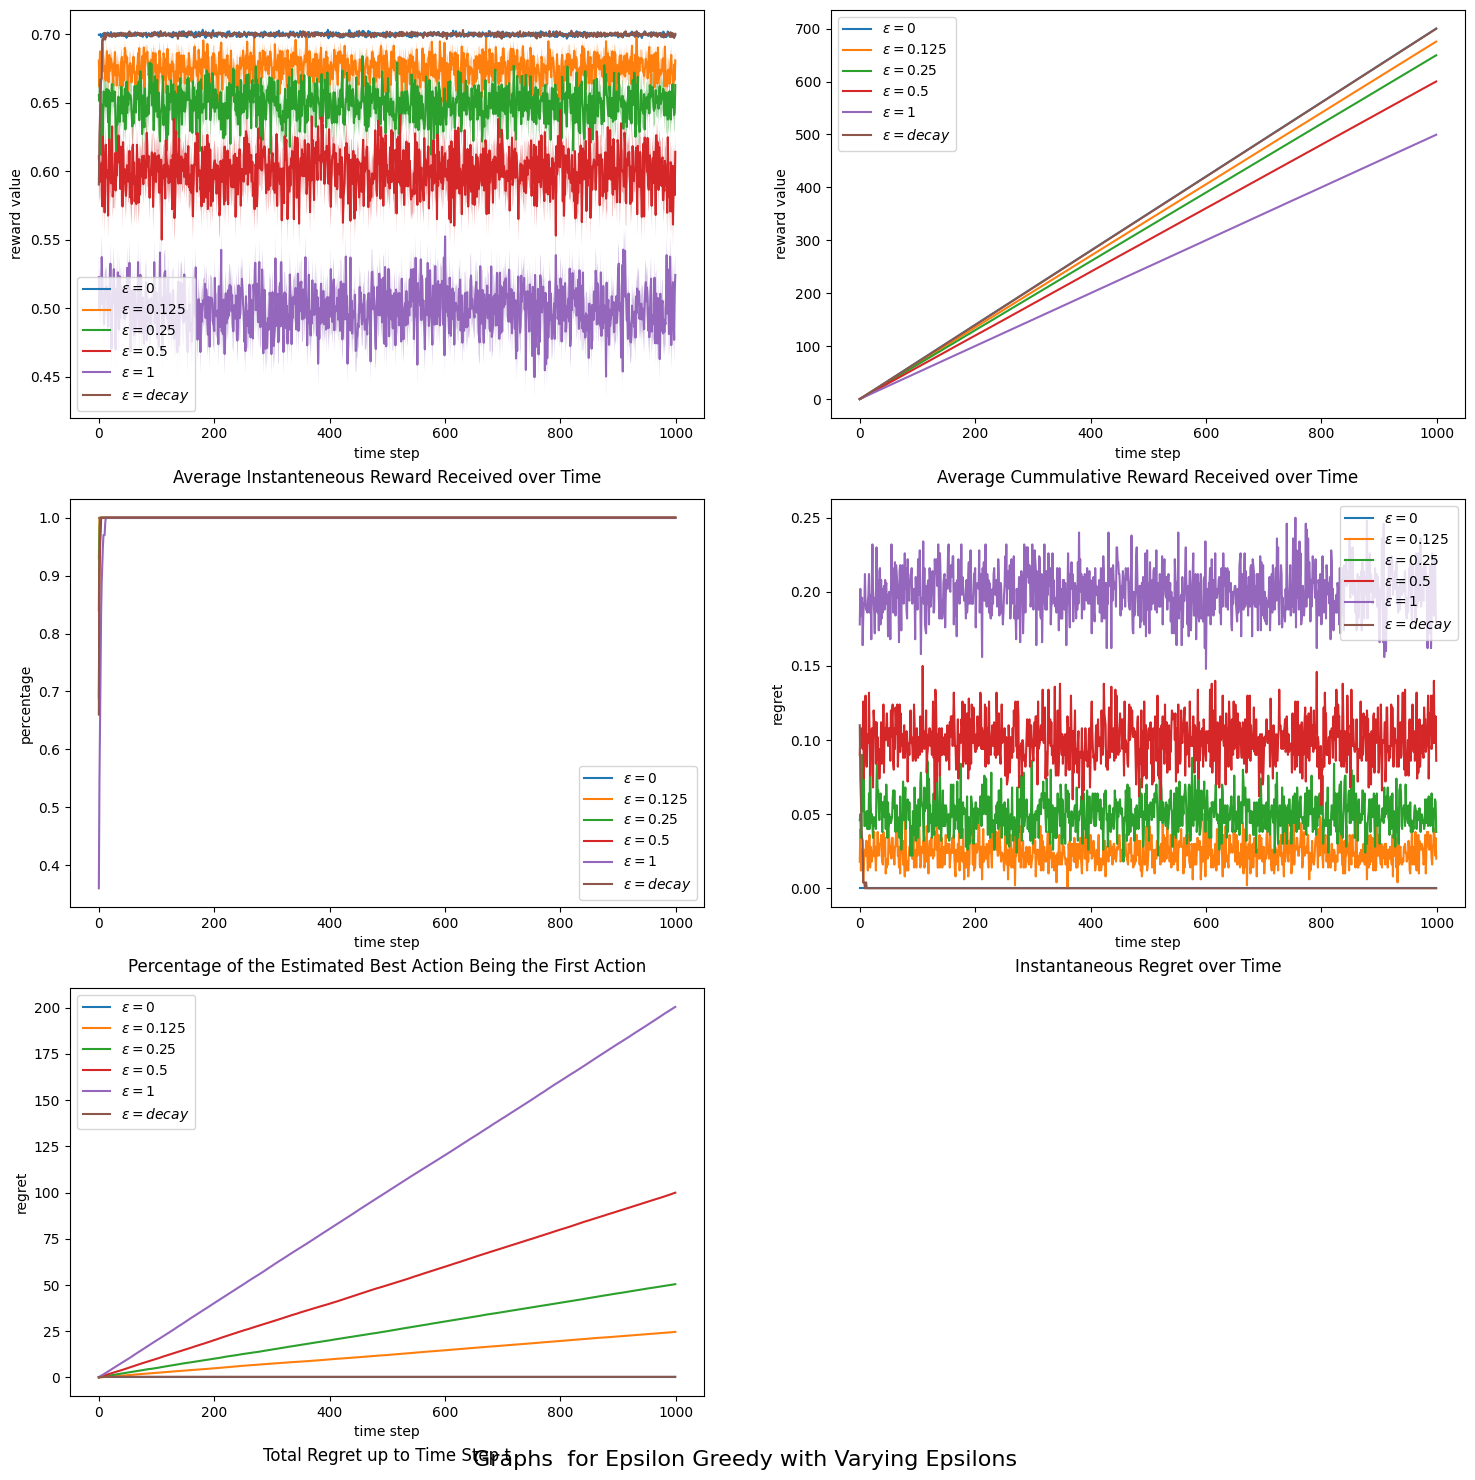

In [11]:
epsilons = [0, 1 / 8, 1 / 4, 1 / 2, 1]
decaying_epsilon_params = {"epsilon_0": 0.5, "lambda_": 0.1}

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))

for epsilon in epsilons + ["decay"]:

    # arrays of the data generated from 100 runs
    R_over_t_runs = []
    total_R_over_t_runs = []
    est_is_best_over_t_runs = []
    l_over_t_runs = []
    total_l_over_t_runs = []

    for run in range(100):
        if epsilon == "decay":
            R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = (
                epsilon_greedy(
                    three_arm_gaussian_bandit,
                    decaying_epsilon_params["epsilon_0"],
                    epsilon_decay=True,
                    lambda_=decaying_epsilon_params["lambda_"],
                )
            )
        else:
            R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = (
                epsilon_greedy(three_arm_gaussian_bandit, epsilon)
            )
        R_over_t_runs.append(R_over_t)
        total_R_over_t_runs.append(total_R_over_t)
        est_is_best_over_t_runs.append(est_is_best_over_t)
        l_over_t_runs.append(l_over_t)
        total_l_over_t_runs.append(total_l_over_t)

    R_over_t_runs = np.asarray(R_over_t_runs)
    total_R_over_t_runs = np.asarray(total_R_over_t_runs)
    est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
    l_over_t_runs = np.asarray(l_over_t_runs)
    total_l_over_t_runs = np.asarray(total_l_over_t_runs)

    # plot the mean reward over time

    mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
    std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(
        np.size(R_over_t_runs, axis=0)
    )

    axs[0, 0].plot(mean_R_over_t_runs, label=r"$\epsilon = %s$" % epsilon)

    R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
    R_over_t_plus_std_err = mean_R_over_t_runs + std_err_R_over_t_runs
    axs[0, 0].fill_between(
        range(0, 1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4
    )
    # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

    axs[0, 0].legend()
    axs[0, 0].set_xlabel("time step")
    axs[0, 0].set_ylabel("reward value")
    axs[0, 0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

    # plot the mean cummulative reward over time

    mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
    std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(
        np.size(total_R_over_t_runs, axis=0)
    )

    axs[0, 1].plot(mean_total_R_over_t_runs, label=r"$\epsilon = %s$" % epsilon)

    total_R_over_t_minus_std_err = (
        mean_total_R_over_t_runs - std_err_total_R_over_t_runs
    )
    total_R_over_t_plus_std_err = mean_total_R_over_t_runs + std_err_total_R_over_t_runs
    axs[0, 1].fill_between(
        range(0, 1000),
        total_R_over_t_minus_std_err,
        total_R_over_t_plus_std_err,
        alpha=0.4,
    )

    axs[0, 1].legend()
    axs[0, 1].set_xlabel("time step")
    axs[0, 1].set_ylabel("reward value")
    axs[0, 1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

    # plot the mean percentage of the estimated best action being the first action

    est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
    (plt_est_is_best_over_t_runs_avgs,) = axs[1, 0].plot(
        est_is_best_over_t_runs_avgs, label=r"$\epsilon = %s$" % epsilon
    )

    axs[1, 0].legend()
    axs[1, 0].set_xlabel("time step")
    axs[1, 0].set_ylabel("percentage")
    axs[1, 0].set_title(
        "Percentage of the Estimated Best Action Being the First Action", y=-0.18
    )

    # plot the mean instantaneous regret over time

    l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
    axs[1, 1].plot(l_over_t_runs_avgs, label=r"$\epsilon = %s$" % epsilon)

    axs[1, 1].legend()
    axs[1, 1].set_xlabel("time step")
    axs[1, 1].set_ylabel("regret")
    axs[1, 1].set_title("Instantaneous Regret over Time", y=-0.18)

    # plot the total regret over time

    total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
    axs[2, 0].plot(total_l_over_t_runs_avgs, label=r"$\epsilon = %s$" % epsilon)

    axs[2, 0].legend()
    axs[2, 0].set_xlabel("time step")
    axs[2, 0].set_ylabel("regret")
    axs[2, 0].set_title("Total Regret up to Time Step t", y=-0.18)

axs[-1, -1].axis("off")

title = r"Graphs  for Epsilon Greedy with Varying Epsilons"
fig.suptitle(title, fontsize=16, y=0.08)

plt.show()

### Answers

## Q5 Hyperparameters for Epsilon-greedy

To have a plain start, you have been provided with predefined functions for generating plots until now. However, moving forward, you are expected to plot graphs on your own.

### Graphs

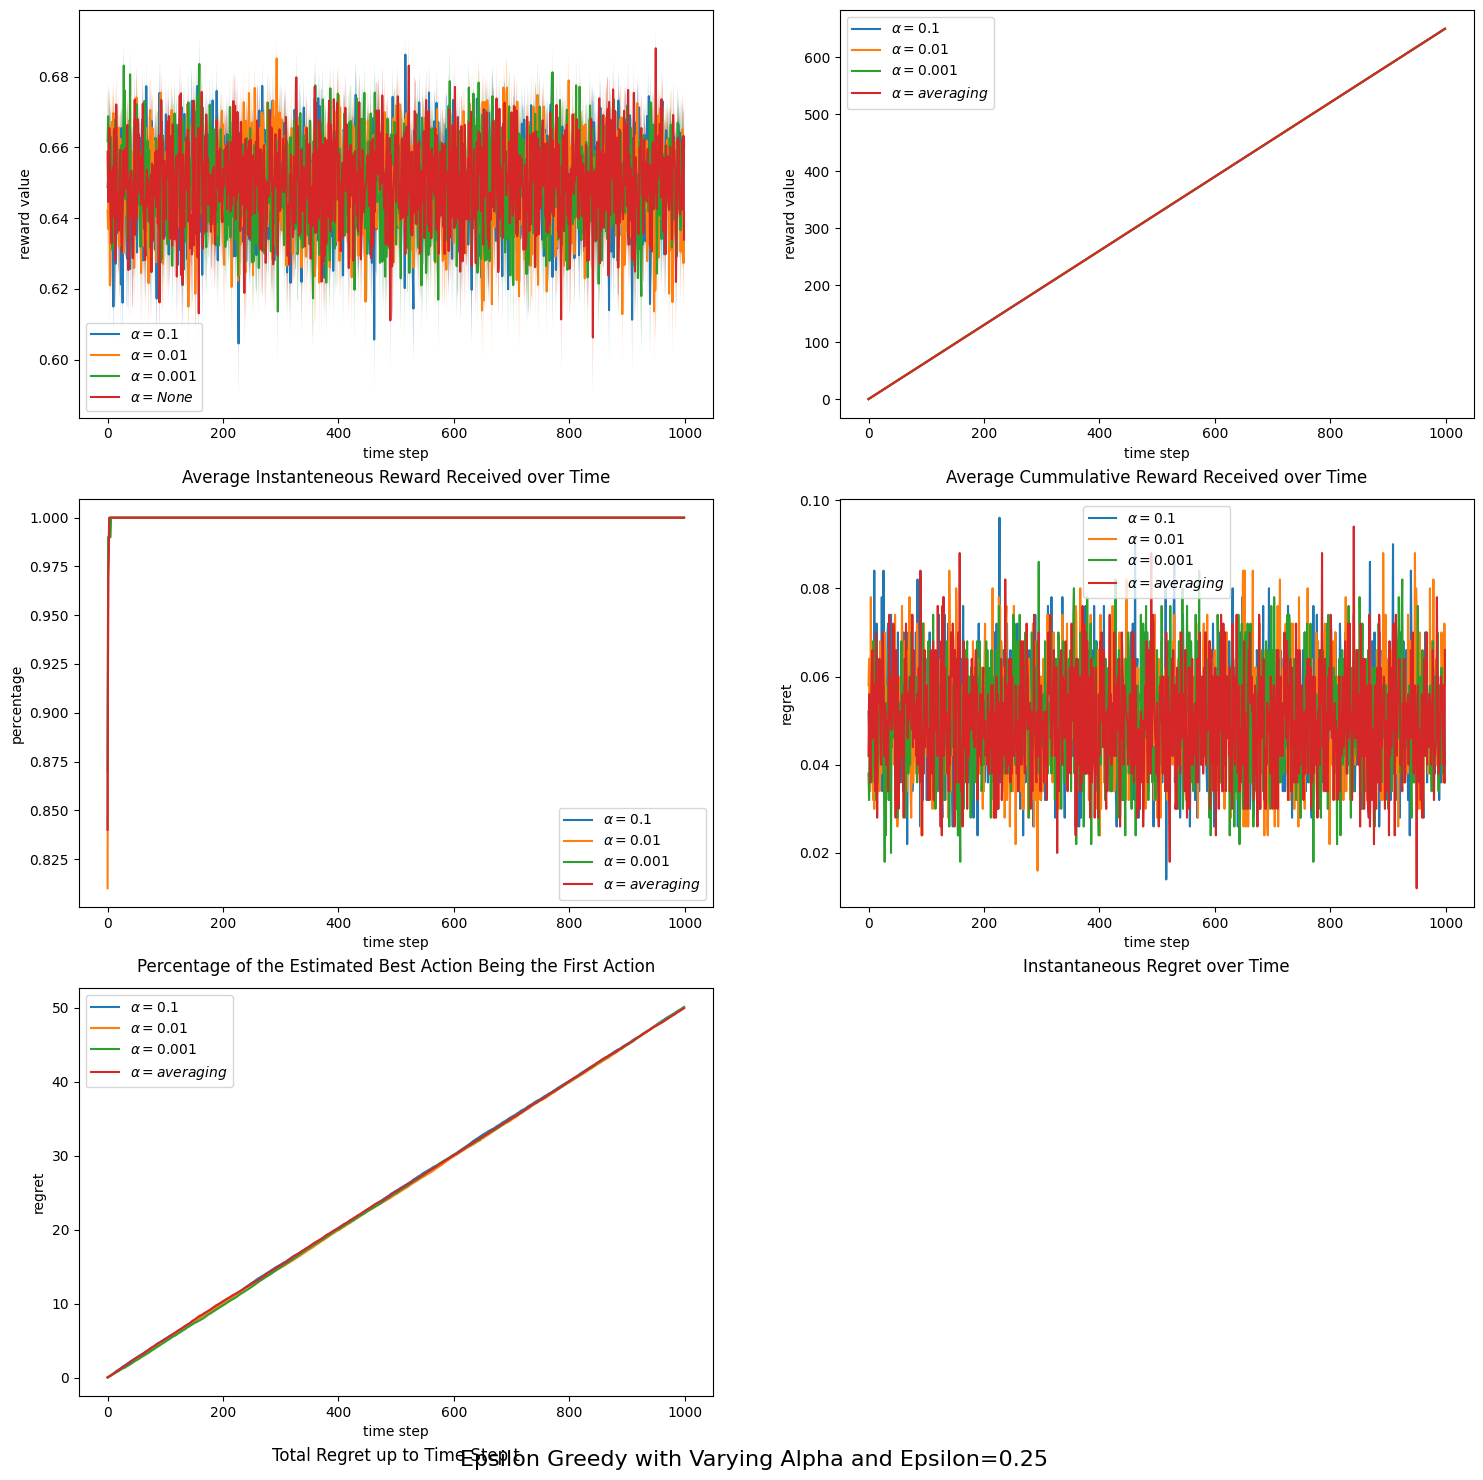

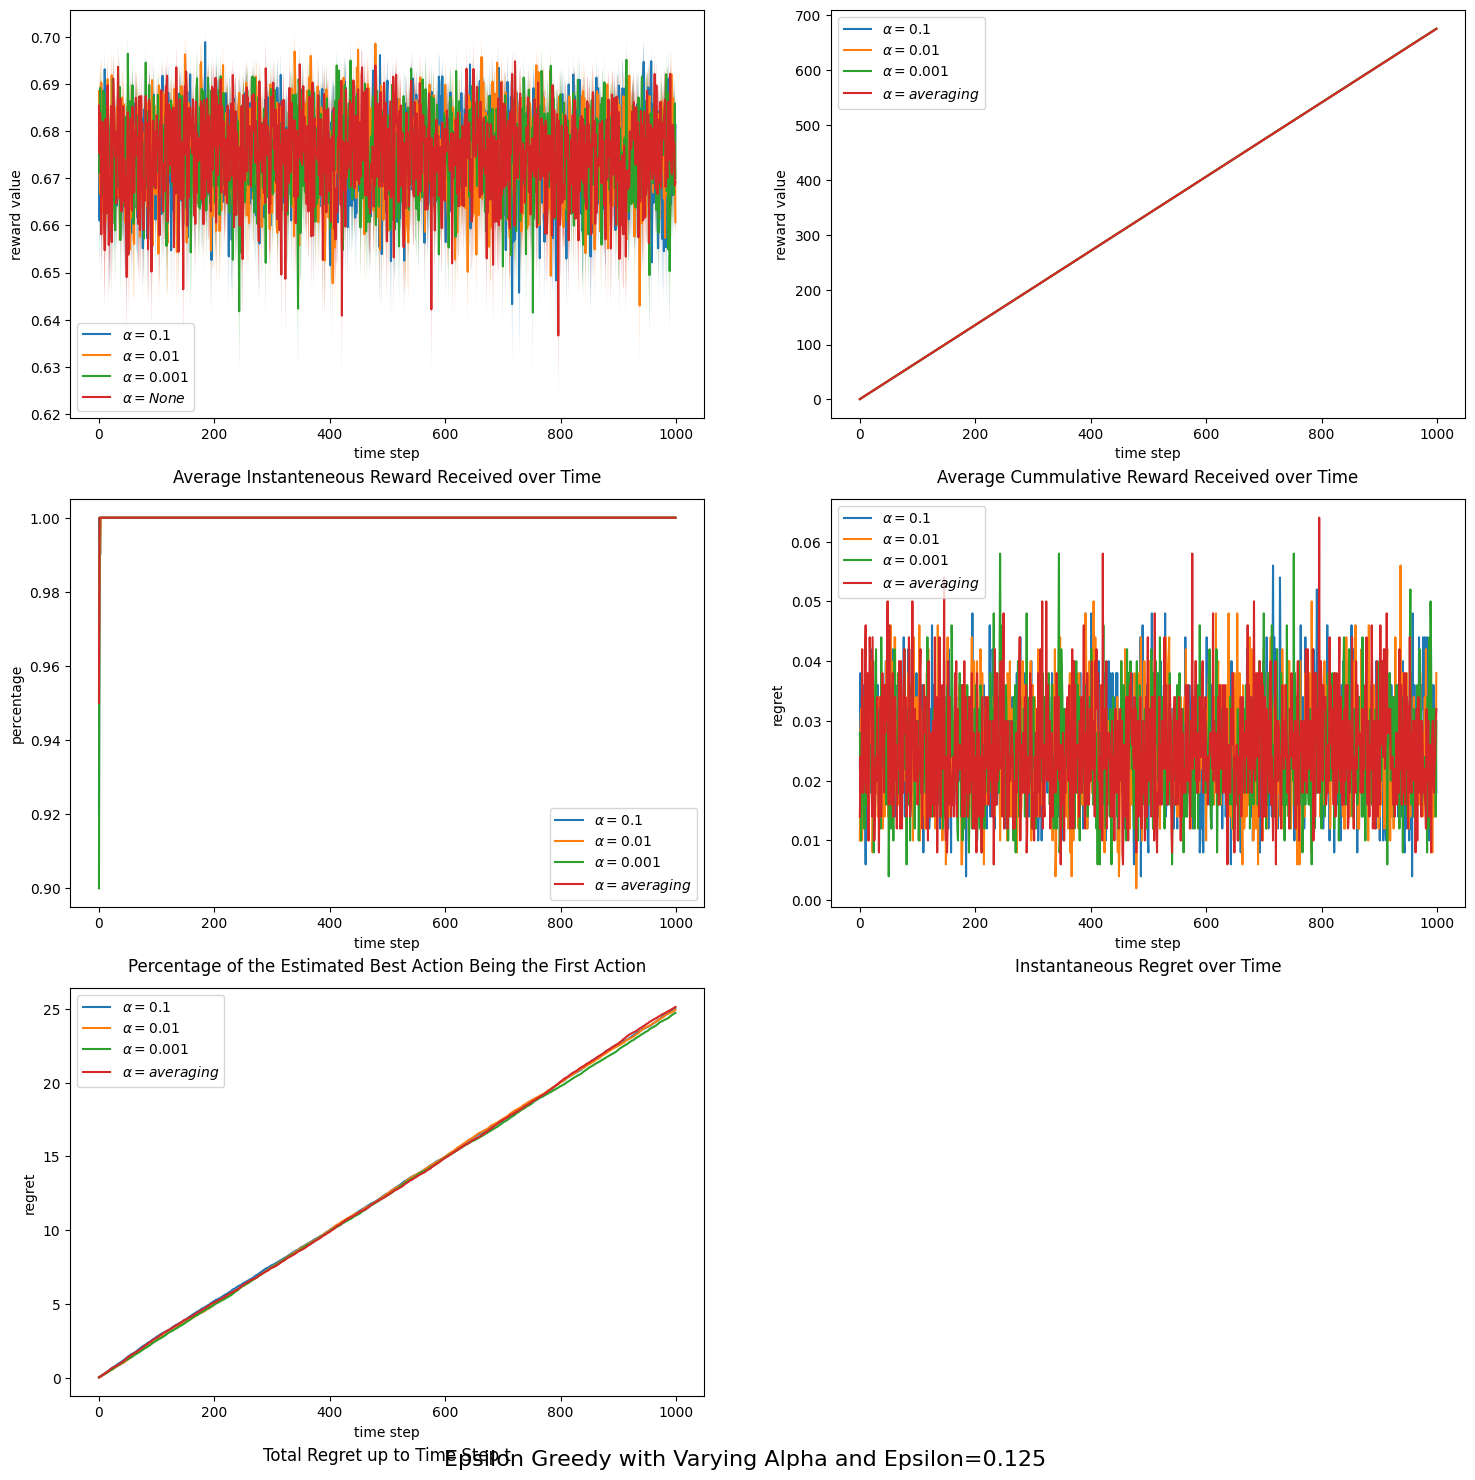

In [12]:
epsilons = [1 / 4, 1 / 8]
alphas = [0.1, 0.01, 0.001, None]


for epsilon in epsilons:
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
    for alpha in alphas:

        # arrays of the data generated from 100 runs
        R_over_t_runs = []
        total_R_over_t_runs = []
        est_is_best_over_t_runs = []
        l_over_t_runs = []
        total_l_over_t_runs = []
        # 100 runs
        for run in range(100):
            R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = (
                epsilon_greedy(three_arm_gaussian_bandit, epsilon, alpha=alpha)
            )

            if alpha is None:
                alpha_str = "averaging"
            else:
                alpha_str = str(alpha)

            R_over_t_runs.append(R_over_t)
            total_R_over_t_runs.append(total_R_over_t)
            est_is_best_over_t_runs.append(est_is_best_over_t)
            l_over_t_runs.append(l_over_t)
            total_l_over_t_runs.append(total_l_over_t)

        R_over_t_runs = np.asarray(R_over_t_runs)
        total_R_over_t_runs = np.asarray(total_R_over_t_runs)
        est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
        l_over_t_runs = np.asarray(l_over_t_runs)
        total_l_over_t_runs = np.asarray(total_l_over_t_runs)

        # plot the mean reward over time
        mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
        std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(
            np.size(R_over_t_runs, axis=0)
        )

        axs[0, 0].plot(mean_R_over_t_runs, label=r"$\alpha = %s$" % alpha)

        R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
        R_over_t_plus_std_err = mean_R_over_t_runs + std_err_R_over_t_runs
        axs[0, 0].fill_between(
            range(0, 1000), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4
        )
        # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

        axs[0, 0].legend()
        axs[0, 0].set_xlabel("time step")
        axs[0, 0].set_ylabel("reward value")
        axs[0, 0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

        # plot the mean cummulative reward over time
        mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
        std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(
            np.size(total_R_over_t_runs, axis=0)
        )

        axs[0, 1].plot(mean_total_R_over_t_runs, label=r"$\alpha = %s$" % alpha_str)

        total_R_over_t_minus_std_err = (
            mean_total_R_over_t_runs - std_err_total_R_over_t_runs
        )
        total_R_over_t_plus_std_err = (
            mean_total_R_over_t_runs + std_err_total_R_over_t_runs
        )
        axs[0, 1].fill_between(
            range(0, 1000),
            total_R_over_t_minus_std_err,
            total_R_over_t_plus_std_err,
            alpha=0.4,
        )

        axs[0, 1].legend()
        axs[0, 1].set_xlabel("time step")
        axs[0, 1].set_ylabel("reward value")
        axs[0, 1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

        # plot the mean percentage of the estimated best action being the first action
        est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
        (plt_est_is_best_over_t_runs_avgs,) = axs[1, 0].plot(
            est_is_best_over_t_runs_avgs, label=r"$\alpha = %s$" % alpha_str
        )

        axs[1, 0].legend()
        axs[1, 0].set_xlabel("time step")
        axs[1, 0].set_ylabel("percentage")
        axs[1, 0].set_title(
            "Percentage of the Estimated Best Action Being the First Action", y=-0.18
        )

        # plot the mean instantaneous regret over time
        l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
        axs[1, 1].plot(l_over_t_runs_avgs, label=r"$\alpha = %s$" % alpha_str)

        axs[1, 1].legend()
        axs[1, 1].set_xlabel("time step")
        axs[1, 1].set_ylabel("regret")
        axs[1, 1].set_title("Instantaneous Regret over Time", y=-0.18)

        # plot the total regret over time
        total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
        axs[2, 0].plot(total_l_over_t_runs_avgs, label=r"$\alpha = %s$" % alpha_str)

        axs[2, 0].legend()
        axs[2, 0].set_xlabel("time step")
        axs[2, 0].set_ylabel("regret")
        axs[2, 0].set_title("Total Regret up to Time Step t", y=-0.18)

    axs[-1, -1].axis("off")

    title = r"Epsilon Greedy with Varying Alpha and Epsilon=" + str(epsilon)
    fig.suptitle(title, fontsize=16, y=0.08)

    plt.show()

### Answers

In the above graphs, we can see that the effect of alpha is only on the third graph (middle left), and variations in the other graphs are due entirely to random number generation. We see that with larger alphas and incremental averaging, the percentage of the estimated first action being the first action converges more slowly to one or even diverges.

## Q6 Gradient Bandit

In [13]:
def gradient_bandit(bandit, alpha=0.1, num_time_step=1000, lambda_=0.001):
    num_arms = bandit.num_arms

    Q_arr = np.zeros(num_arms)
    N_arr = np.zeros(num_arms)
    total_R = 0
    total_l = 0
    actions = range(num_arms)

    opt_value = max(bandit.mean)
    best_action = bandit.mean.index(opt_value)

    R_over_t = []
    total_R_over_t = []
    est_is_best_over_t = []
    l_over_t = []
    total_l_over_t = []

    H = np.zeros(num_arms)

    if alpha == "decaying":
        alpha_0 = 0.5
        p = 0.5

    for time_step in range(num_time_step):
        if alpha == "decaying":
            alpha = alpha_0 / ((1 + lambda_ * time_step) ** p)
        exp_H = np.exp(H)
        exp_H_sum = np.sum(exp_H)

        pi = exp_H / exp_H_sum
        A = np.random.choice(range(num_arms), p=pi)
        curr_R = bandit.sample(A)
        avg_R = np.mean(R_over_t) if len(R_over_t) > 0 else curr_R

        for action in range(num_arms):
            H[action] += alpha * (curr_R - avg_R) * (1.0 - pi[action])

        R_over_t.append(curr_R)

        total_R = total_R + curr_R
        total_R_over_t.append(total_R)

        est_is_best = 1 if bandit.mean[Q_arr.argmax()] == opt_value else 0
        est_is_best_over_t.append(est_is_best)

        l_t = bandit.mean[best_action] - bandit.mean[A]
        l_over_t.append(l_t)

        total_l = total_l + l_t
        total_l_over_t.append(total_l)
    return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

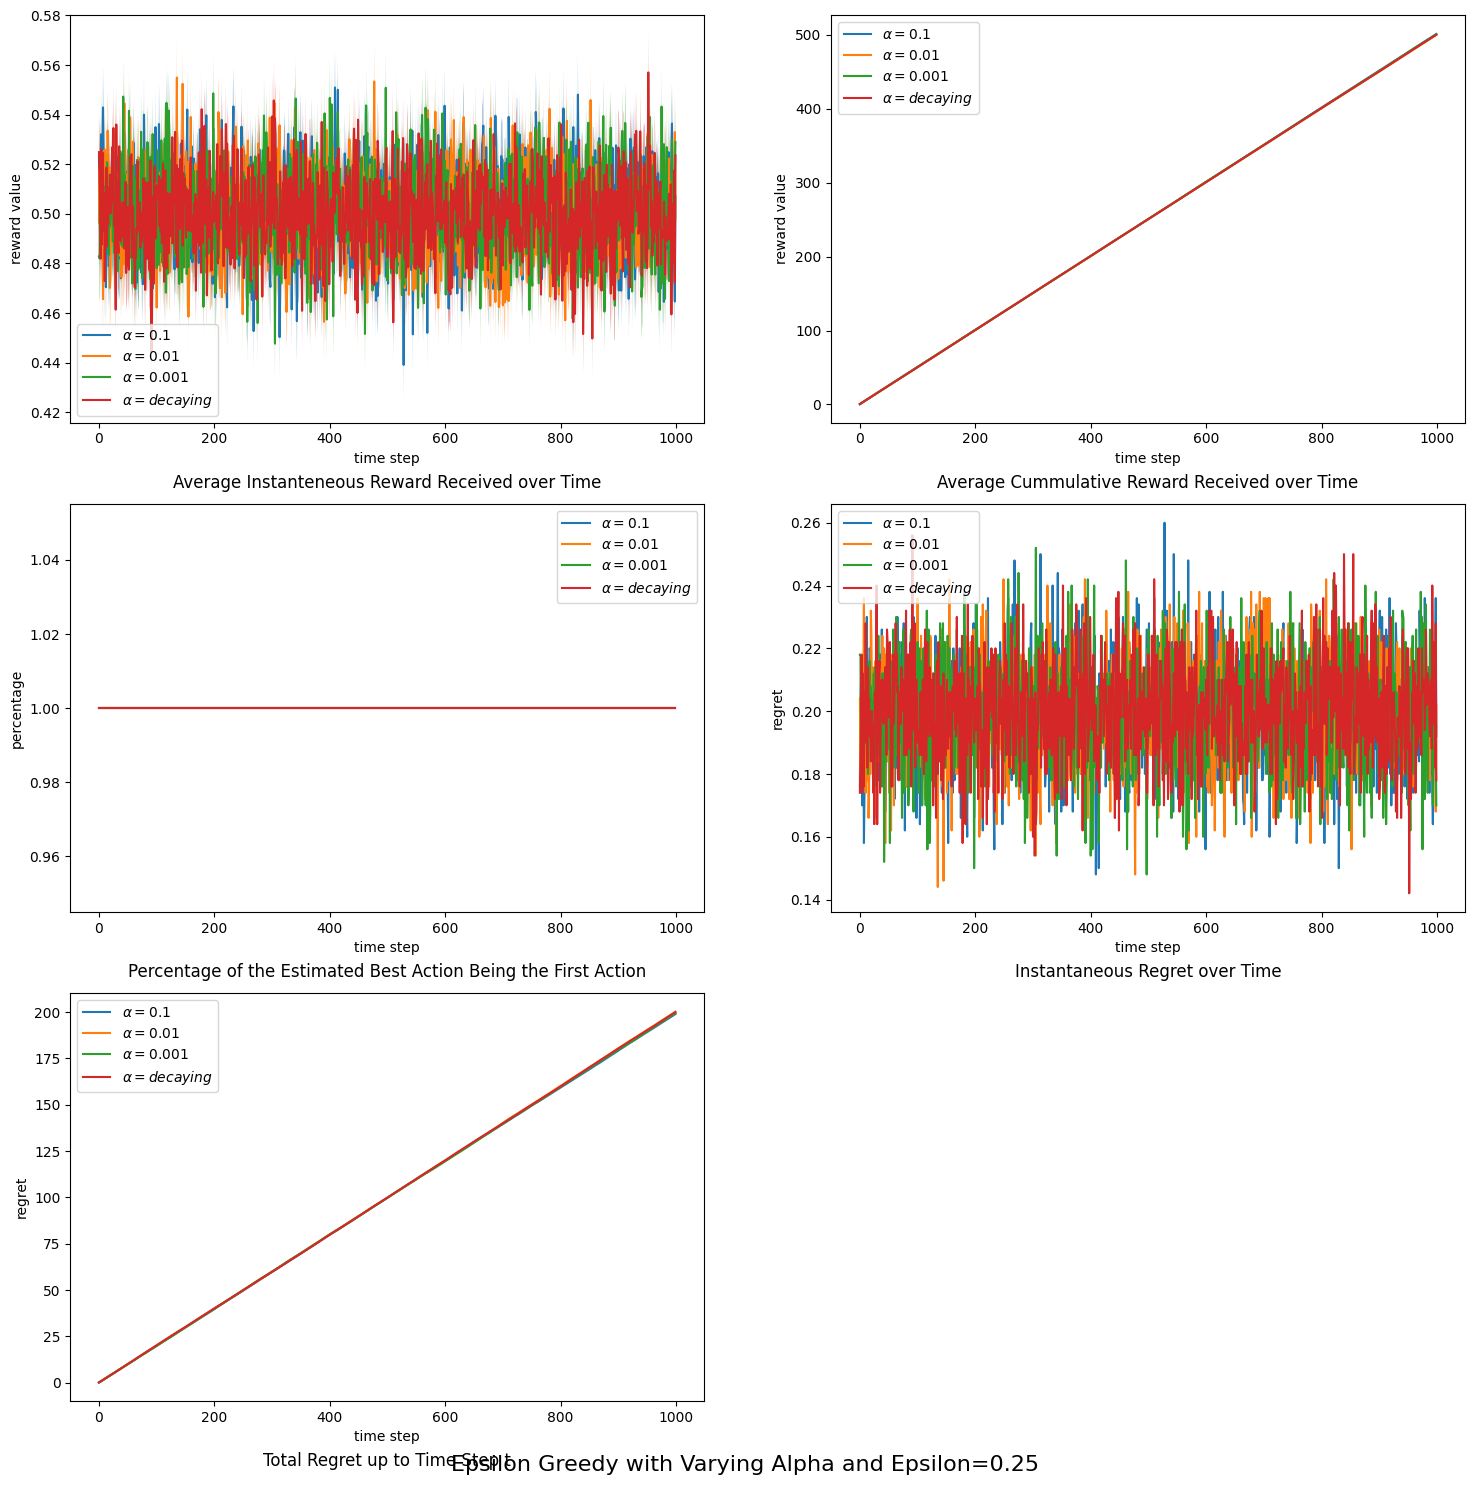

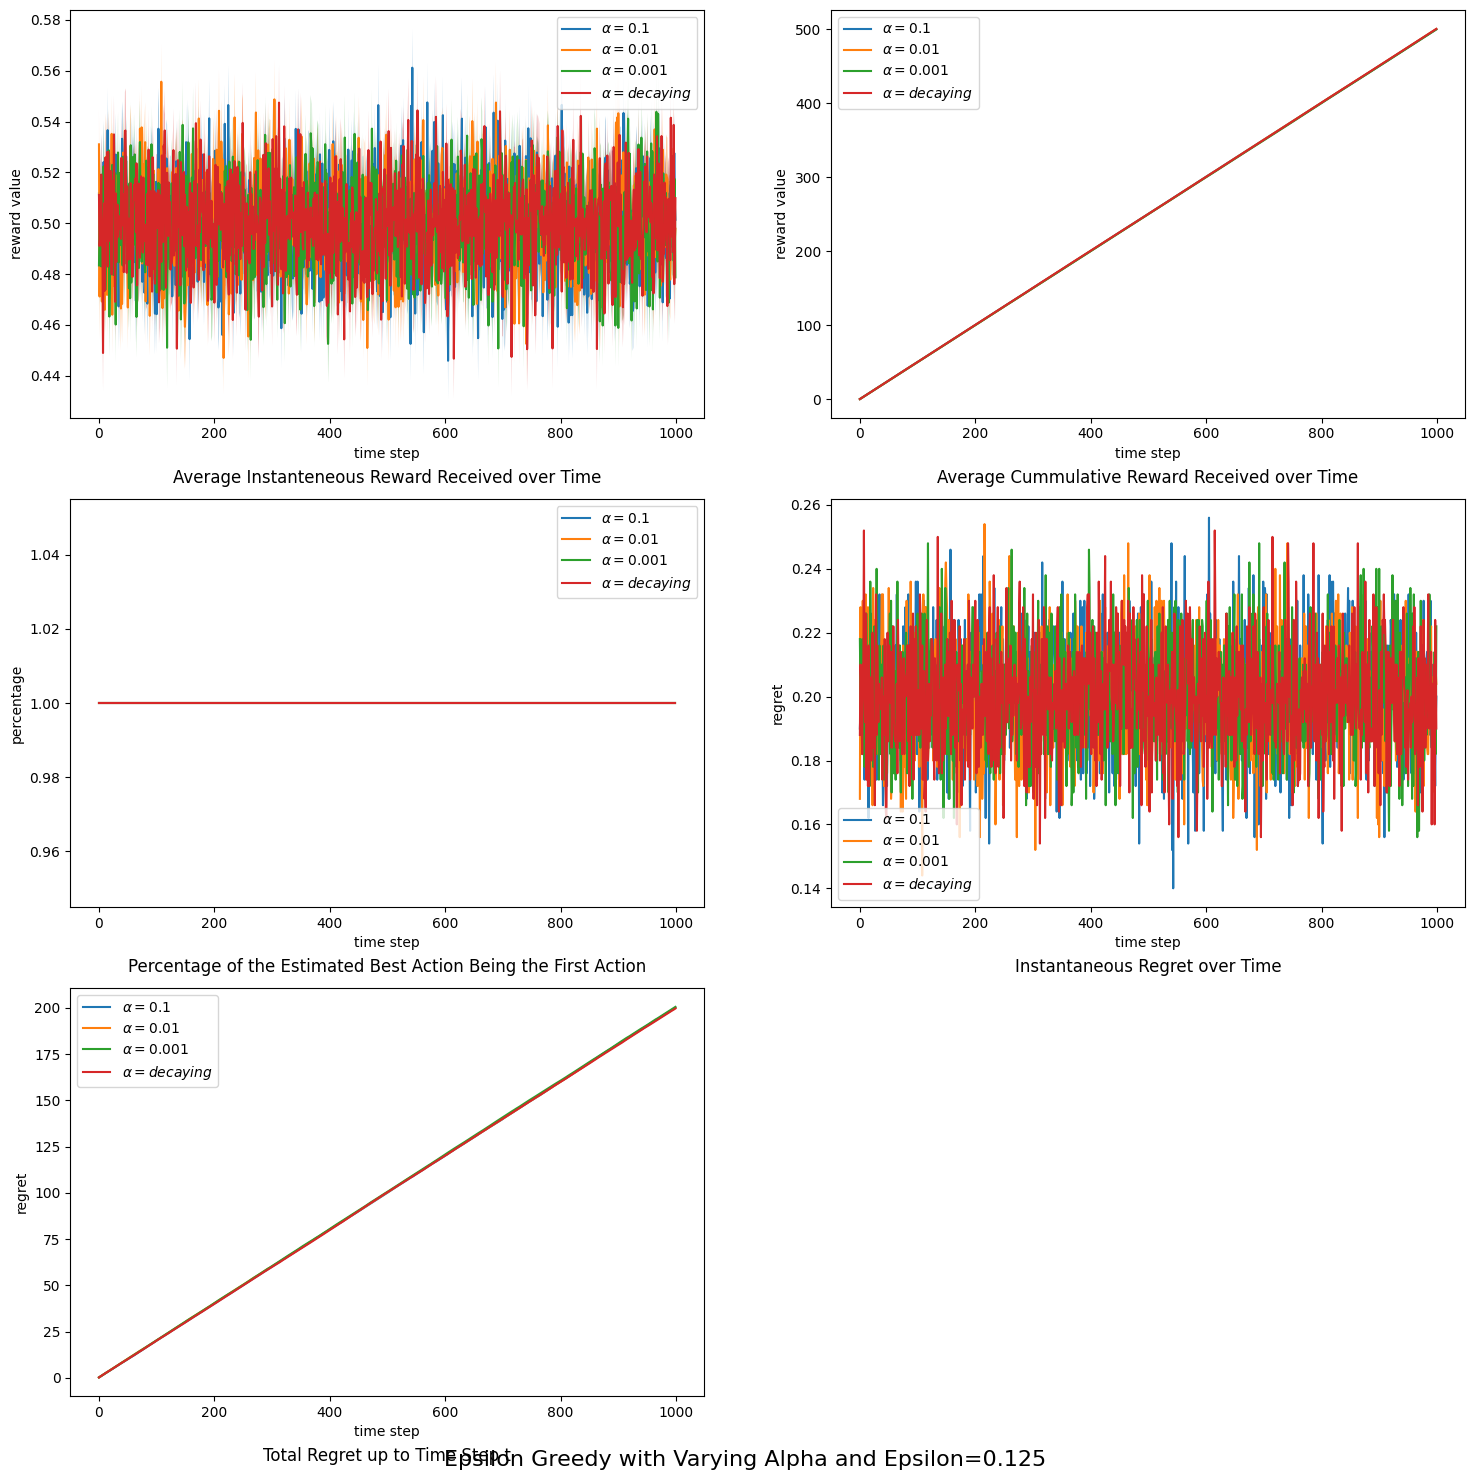

In [14]:
epsilons = [1 / 4, 1 / 8]
alphas = [0.1, 0.01, 0.001, "decaying"]

num_time_step=1000

for epsilon in epsilons:
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
    for alpha in alphas:

        # arrays of the data generated from 100 runs
        R_over_t_runs = []
        total_R_over_t_runs = []
        est_is_best_over_t_runs = []
        l_over_t_runs = []
        total_l_over_t_runs = []
        # 100 runs
        for run in range(100):
            R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = (
                gradient_bandit(three_arm_gaussian_bandit, alpha=alpha, num_time_step=num_time_step)
            )

            if alpha is None:
                alpha_str = "averaging"
            if alpha == "decaying":
                alpha_str = "decaying"
            else:
                alpha_str = str(alpha)

            R_over_t_runs.append(R_over_t)
            total_R_over_t_runs.append(total_R_over_t)
            est_is_best_over_t_runs.append(est_is_best_over_t)
            l_over_t_runs.append(l_over_t)
            total_l_over_t_runs.append(total_l_over_t)

        R_over_t_runs = np.asarray(R_over_t_runs)
        total_R_over_t_runs = np.asarray(total_R_over_t_runs)
        est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
        l_over_t_runs = np.asarray(l_over_t_runs)
        total_l_over_t_runs = np.asarray(total_l_over_t_runs)

        # plot the mean reward over time
        mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
        std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(
            np.size(R_over_t_runs, axis=0)
        )

        axs[0, 0].plot(mean_R_over_t_runs, label=r"$\alpha = %s$" % alpha)

        R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
        R_over_t_plus_std_err = mean_R_over_t_runs + std_err_R_over_t_runs
        axs[0, 0].fill_between(
            range(0, num_time_step), R_over_t_minus_std_err, R_over_t_plus_std_err, alpha=0.4
        )
        # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

        axs[0, 0].legend()
        axs[0, 0].set_xlabel("time step")
        axs[0, 0].set_ylabel("reward value")
        axs[0, 0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

        # plot the mean cummulative reward over time
        mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
        std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(
            np.size(total_R_over_t_runs, axis=0)
        )

        axs[0, 1].plot(mean_total_R_over_t_runs, label=r"$\alpha = %s$" % alpha_str)

        total_R_over_t_minus_std_err = (
            mean_total_R_over_t_runs - std_err_total_R_over_t_runs
        )
        total_R_over_t_plus_std_err = (
            mean_total_R_over_t_runs + std_err_total_R_over_t_runs
        )
        axs[0, 1].fill_between(
            range(0, num_time_step),
            total_R_over_t_minus_std_err,
            total_R_over_t_plus_std_err,
            alpha=0.4,
        )

        axs[0, 1].legend()
        axs[0, 1].set_xlabel("time step")
        axs[0, 1].set_ylabel("reward value")
        axs[0, 1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

        # plot the mean percentage of the estimated best action being the first action
        est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
        (plt_est_is_best_over_t_runs_avgs,) = axs[1, 0].plot(
            est_is_best_over_t_runs_avgs, label=r"$\alpha = %s$" % alpha_str
        )

        axs[1, 0].legend()
        axs[1, 0].set_xlabel("time step")
        axs[1, 0].set_ylabel("percentage")
        axs[1, 0].set_title(
            "Percentage of the Estimated Best Action Being the First Action", y=-0.18
        )

        # plot the mean instantaneous regret over time
        l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
        axs[1, 1].plot(l_over_t_runs_avgs, label=r"$\alpha = %s$" % alpha_str)

        axs[1, 1].legend()
        axs[1, 1].set_xlabel("time step")
        axs[1, 1].set_ylabel("regret")
        axs[1, 1].set_title("Instantaneous Regret over Time", y=-0.18)

        # plot the total regret over time
        total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
        axs[2, 0].plot(total_l_over_t_runs_avgs, label=r"$\alpha = %s$" % alpha_str)

        axs[2, 0].legend()
        axs[2, 0].set_xlabel("time step")
        axs[2, 0].set_ylabel("regret")
        axs[2, 0].set_title("Total Regret up to Time Step t", y=-0.18)

    axs[-1, -1].axis("off")

    title = r"Epsilon Greedy with Varying Alpha and Epsilon=" + str(epsilon)
    fig.suptitle(title, fontsize=16, y=0.08)

    plt.show()

### Answers

## Q7 Thompson Sampling

In [1]:
# TODO check this whole function
def thompson_sampling(
    bandit, mean_prior=0, variance_prior=100, num_time_step=1000, lambda_=0.001
):
    num_arms = bandit.num_arms

    Q_arr = np.zeros(num_arms)
    N_arr = np.zeros(num_arms)
    total_R = 0
    total_l = 0
    actions = range(num_arms)

    opt_value = max(bandit.mean)
    best_action = bandit.mean.index(opt_value)

    R_over_t = []
    total_R_over_t = []
    est_is_best_over_t = []
    l_over_t = []
    total_l_over_t = []

    # Posterior mean and variance
    mean_post = np.full(num_arms, mean_prior, dtype=float)
    variance_post = np.full(num_arms, variance_prior, dtype=float)

    for time_step in range(num_time_step):
        sampled_means = np.random.normal(mean_post, np.sqrt(variance_post))
        A = np.argmax(sampled_means)
        curr_R = bandit.sample(A)
        N_arr[A] = N_arr[A] + 1

        # mean_post[A] = (mean_post[A] * N_arr[A]) + curr_R / (N_arr[A] + 1)
        # variance_post[A] = variance_post[A] / (N_arr[A] + 1)

        variance_post[A] = (1 / variance_prior + N_arr[A]) ** (-1)
        mean_post[A] = variance_post[A] * (np.sum(R_over_t))

        R_over_t.append(curr_R)

        total_R = total_R + curr_R
        total_R_over_t.append(total_R)

        # TODO check this
        est_is_best = 1 if bandit.mean[Q_arr.argmax()] == opt_value else 0
        est_is_best_over_t.append(est_is_best)

        l_t = bandit.mean[best_action] - bandit.mean[A]
        l_over_t.append(l_t)

        total_l = total_l + l_t
        total_l_over_t.append(total_l)
    return R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t

### Graphs

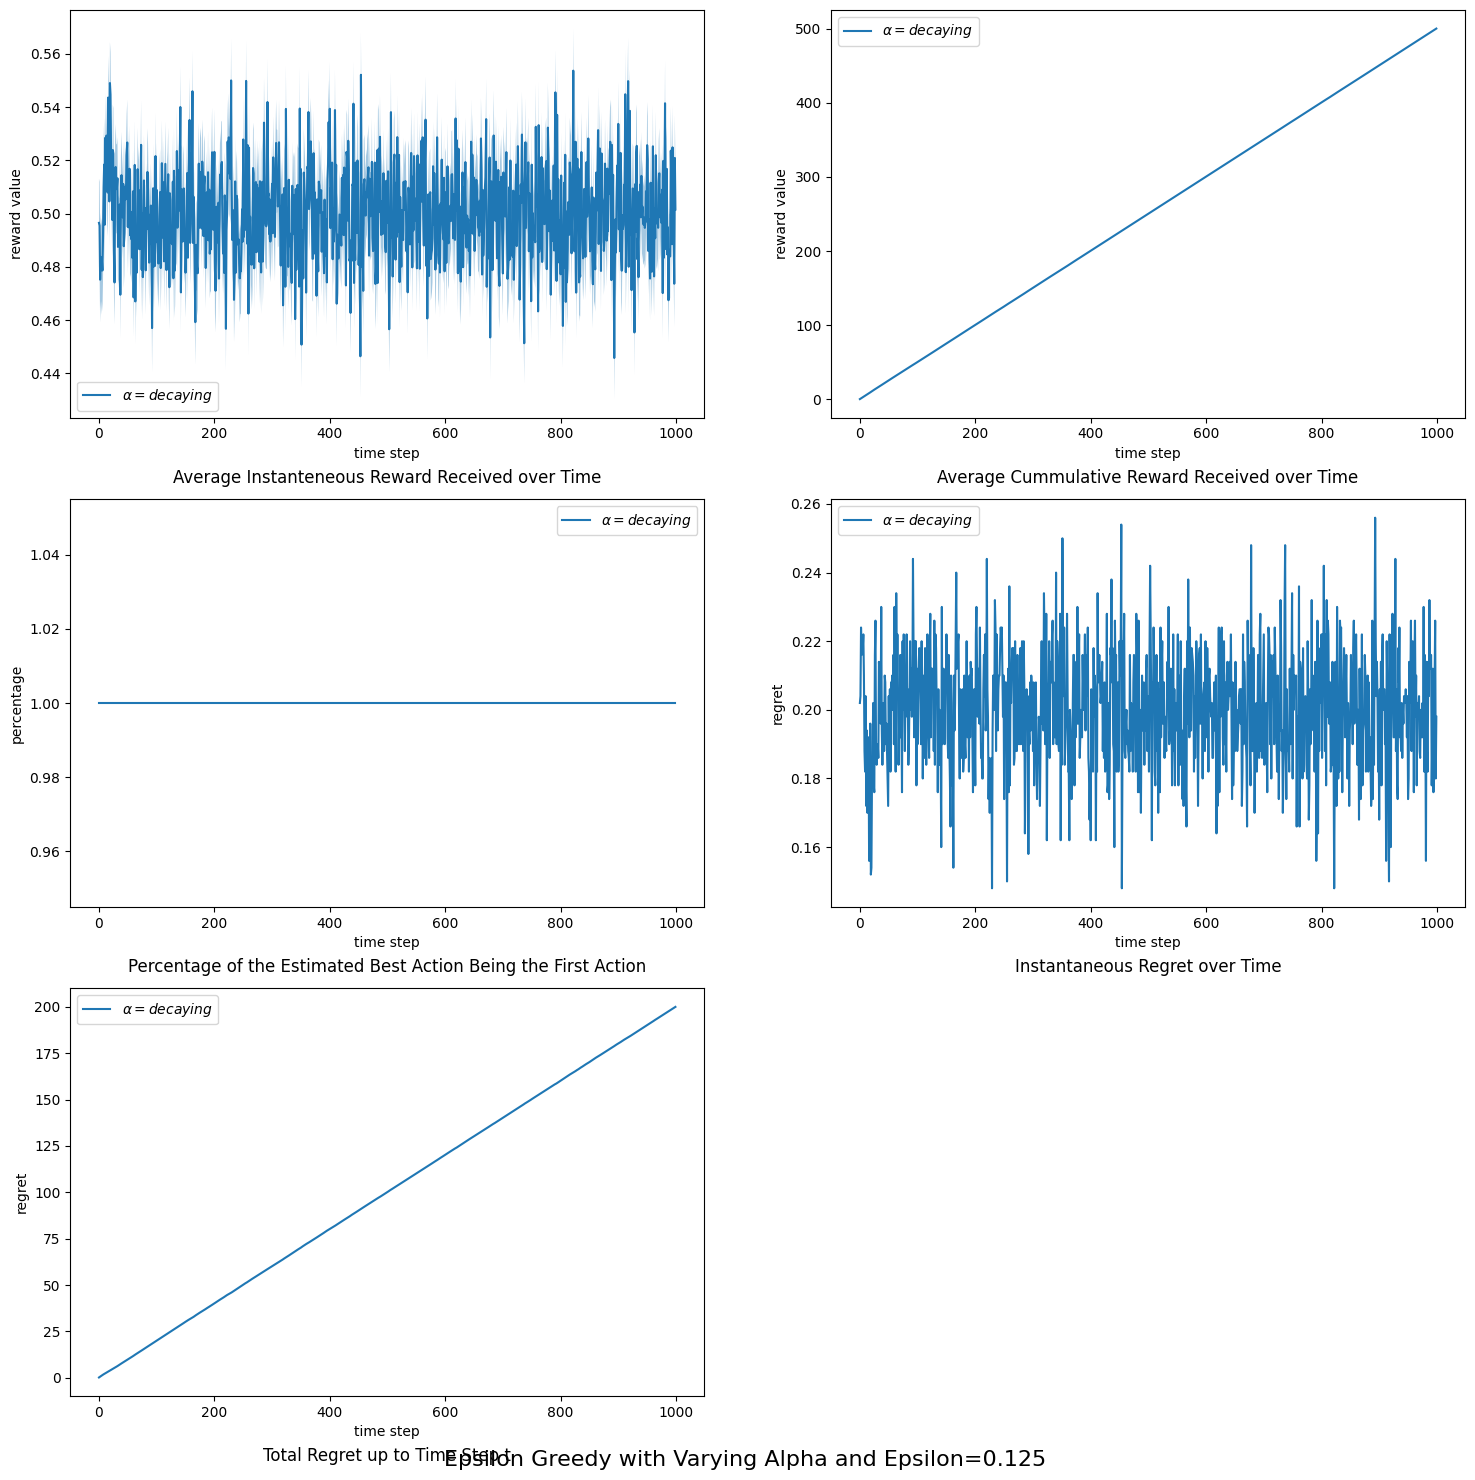

In [21]:
# epsilons = [1 / 4, 1 / 8]
# alphas = [0.1, 0.01, 0.001, "decaying"]

num_time_step = 1000

# for epsilon in epsilons:
for i in range(1):
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
    # for alpha in alphas:
    for i in range(1):

        # arrays of the data generated from 100 runs
        R_over_t_runs = []
        total_R_over_t_runs = []
        est_is_best_over_t_runs = []
        l_over_t_runs = []
        total_l_over_t_runs = []
        # 100 runs
        for run in range(100):
            R_over_t, total_R_over_t, est_is_best_over_t, l_over_t, total_l_over_t = (
                thompson_sampling(
                    three_arm_gaussian_bandit, num_time_step=num_time_step
                )
            )

            if alpha is None:
                alpha_str = "averaging"
            if alpha == "decaying":
                alpha_str = "decaying"
            else:
                alpha_str = str(alpha)

            R_over_t_runs.append(R_over_t)
            total_R_over_t_runs.append(total_R_over_t)
            est_is_best_over_t_runs.append(est_is_best_over_t)
            l_over_t_runs.append(l_over_t)
            total_l_over_t_runs.append(total_l_over_t)

        R_over_t_runs = np.asarray(R_over_t_runs)
        total_R_over_t_runs = np.asarray(total_R_over_t_runs)
        est_is_best_over_t_runs = np.asarray(est_is_best_over_t_runs)
        l_over_t_runs = np.asarray(l_over_t_runs)
        total_l_over_t_runs = np.asarray(total_l_over_t_runs)

        # plot the mean reward over time
        mean_R_over_t_runs = np.mean(R_over_t_runs, axis=0)
        std_err_R_over_t_runs = np.std(R_over_t_runs, axis=0) / np.sqrt(
            np.size(R_over_t_runs, axis=0)
        )

        axs[0, 0].plot(mean_R_over_t_runs, label=r"$\alpha = %s$" % alpha)

        R_over_t_minus_std_err = mean_R_over_t_runs - std_err_R_over_t_runs
        R_over_t_plus_std_err = mean_R_over_t_runs + std_err_R_over_t_runs
        axs[0, 0].fill_between(
            range(0, num_time_step),
            R_over_t_minus_std_err,
            R_over_t_plus_std_err,
            alpha=0.4,
        )
        # axs[0,0].errorbar(range(0,1000), mean_R_over_t_runs, yerr=std_err_R_over_t_runs)

        axs[0, 0].legend()
        axs[0, 0].set_xlabel("time step")
        axs[0, 0].set_ylabel("reward value")
        axs[0, 0].set_title("Average Instanteneous Reward Received over Time", y=-0.18)

        # plot the mean cummulative reward over time
        mean_total_R_over_t_runs = np.mean(total_R_over_t_runs, axis=0)
        std_err_total_R_over_t_runs = np.std(total_R_over_t_runs, axis=0) / np.sqrt(
            np.size(total_R_over_t_runs, axis=0)
        )

        axs[0, 1].plot(mean_total_R_over_t_runs, label=r"$\alpha = %s$" % alpha_str)

        total_R_over_t_minus_std_err = (
            mean_total_R_over_t_runs - std_err_total_R_over_t_runs
        )
        total_R_over_t_plus_std_err = (
            mean_total_R_over_t_runs + std_err_total_R_over_t_runs
        )
        axs[0, 1].fill_between(
            range(0, num_time_step),
            total_R_over_t_minus_std_err,
            total_R_over_t_plus_std_err,
            alpha=0.4,
        )

        axs[0, 1].legend()
        axs[0, 1].set_xlabel("time step")
        axs[0, 1].set_ylabel("reward value")
        axs[0, 1].set_title("Average Cummulative Reward Received over Time", y=-0.18)

        # plot the mean percentage of the estimated best action being the first action
        est_is_best_over_t_runs_avgs = np.mean(est_is_best_over_t_runs, axis=0)
        (plt_est_is_best_over_t_runs_avgs,) = axs[1, 0].plot(
            est_is_best_over_t_runs_avgs, label=r"$\alpha = %s$" % alpha_str
        )

        axs[1, 0].legend()
        axs[1, 0].set_xlabel("time step")
        axs[1, 0].set_ylabel("percentage")
        axs[1, 0].set_title(
            "Percentage of the Estimated Best Action Being the First Action", y=-0.18
        )

        # plot the mean instantaneous regret over time
        l_over_t_runs_avgs = np.mean(l_over_t_runs, axis=0)
        axs[1, 1].plot(l_over_t_runs_avgs, label=r"$\alpha = %s$" % alpha_str)

        axs[1, 1].legend()
        axs[1, 1].set_xlabel("time step")
        axs[1, 1].set_ylabel("regret")
        axs[1, 1].set_title("Instantaneous Regret over Time", y=-0.18)

        # plot the total regret over time
        total_l_over_t_runs_avgs = np.mean(total_l_over_t_runs, axis=0)
        axs[2, 0].plot(total_l_over_t_runs_avgs, label=r"$\alpha = %s$" % alpha_str)

        axs[2, 0].legend()
        axs[2, 0].set_xlabel("time step")
        axs[2, 0].set_ylabel("regret")
        axs[2, 0].set_title("Total Regret up to Time Step t", y=-0.18)

    axs[-1, -1].axis("off")

    title = r"Epsilon Greedy with Varying Alpha and Epsilon=" + str(epsilon)
    fig.suptitle(title, fontsize=16, y=0.08)

    plt.show()

### Answers

## Q8 Comparison of Algorithms

### Graphs

### Answers

## Q9 Non-stationary Environment

### Answers